In [5]:
# HIDDEN

from datascience import *
import numpy as np
from scipy import stats

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [51]:
# HIDDEN 

baby = Table.read_table('baby.csv')
hybrid = Table.read_table('http://www.stat.ufl.edu/~winner/data/hybrid_reg.csv')
hybrid = hybrid.drop(['carid', 'mpgmpge'])
hybrid = hybrid.relabel('accelrate', 'acceleration')

In [7]:
# HIDDEN

def standard_units(x):
    return (x - np.mean(x))/np.std(x)

def correlation(table, x, y):
    x_in_standard_units = standard_units(table.column(x))
    y_in_standard_units = standard_units(table.column(y))
    return np.mean(x_in_standard_units * y_in_standard_units)

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) -  a * np.mean(table.column(x))

def fitted_value(table, x, y, given_x):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * given_x  + b

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def scatter_fit(table, x, y):
    table.scatter(x, y, s=15)
    plots.plot(table.column(x), fit(table, x, y), lw=2, color='darkblue')
    plots.xlabel(x)
    plots.ylabel(y)

The methods that we have developed for inference in regression are valid if the regression model holds for our data. If the data do not satisfy the assumptions of the model, then it can be hard to justify calculations that assume that the model is good.

In this section we will develop some simple descriptive methods that can help us decide whether our data satisfy the regression model.

We will start with a review of the details of the model, which specifies that the points in the scatter plot are generated at random as follows.
 
- Tyche creates the scatter plot by starting with points that lie perfectly on a straight line and then pushing them off the line vertically, either above or below, as follows:
    - For each $x$, Tyche finds the corresponding point on the true line, and then adds an error.
    - The errors are drawn at random with replacement from a population of errors that has a normal distribution with mean 0 and an unknown standard deviation.
    - Tyche creates a point whose horizontal coordinate is $x$ and whose vertical coordinate is "the height of the true line at $x$, plus the error". If the error is positive, the point is above the line. If the error is negative, the point is below the line.
- We get to see the resulting points but not the true line on which the points started out nor the random errors that Tyche added.

### First Diagnostic: The Scatter Plot
It is always helpful to start with a visualization. Continuing the example of estimating birth weight based on gestational days, let us look at a scatter plot of the two variables.

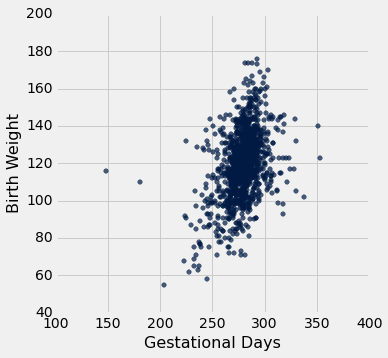

In [3]:
baby.scatter('Gestational Days', 'Birth Weight')

The points do appear to be roughly clustered around a straight line. There is no strikingly noticeable curve in the scatter. 

A plot of the regression line through the scatter plot shows that about half the points are above the line and half are below the line almost symmetrically, supporting the model's assumption that Tyche is adding random errors that are normally distributed with mean 0.

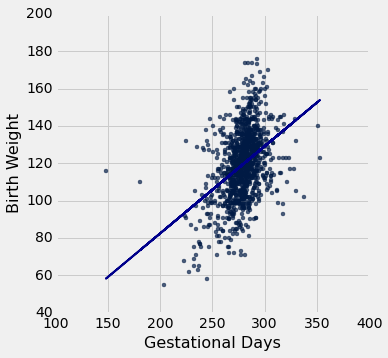

In [24]:
scatter_fit(baby, 'Gestational Days', 'Birth Weight')

### Second Diagnostic: A Residual Plot
We cannot see the true line that is the basis of the regression model, but the regression line that we calculate acts as a substitute for it. So also the vertical distances of the points from the regression line act as substitutes for the random errors that Tyche uses to push the points vertically off the true line.

As we have seen earlier, the vertical distances of the points from the regression line are called *residuals*. There is one residual for each point in the scatter plot. The residual is the difference between the observed value of $y$ and the fitted value of $y$:

For the point $(x, y)$,

$$
\mbox{residual} ~~ = ~~ y ~-~
\mbox{fitted value of }y
~~ = ~~ y ~-~
\mbox{height of regression line at }y
$$

The table ``baby_regression`` contains the data, the fitted values and the residuals:

In [33]:
baby2 = baby.select(['Gestational Days', 'Birth Weight'])
fitted = fit(baby, 'Gestational Days', 'Birth Weight')
residuals = baby.column('Birth Weight') - fitted
baby_regression = baby2.with_columns([
        'Fitted Value', fitted,
        'Residual', residuals
    ])
baby_regression

Gestational Days,Birth Weight,Fitted Value,Residual
284,120,121.748,-1.74801
282,113,120.815,-7.8149
279,128,119.415,8.58477
282,108,120.815,-12.8149
286,136,122.681,13.3189
244,138,103.086,34.9143
245,132,103.552,28.4477
289,120,124.081,-4.0808
299,143,128.746,14.2536
351,140,153.007,-13.0073


Once again, it helps to visualize. The figure below shows four of the residuals; for each of the four points, the length of the red segment is the residual for that point. There is one such residual for each of the other 1170 points as well.

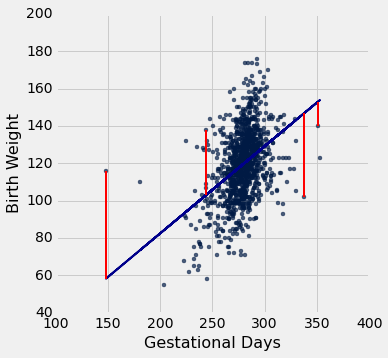

In [25]:
points = Table().with_columns([
        'Gestational Days', [148, 244, 338, 351],
        'Birth Weight', [116, 138, 102, 140]
    ])

scatter_fit(baby, 'Gestational Days', 'Birth Weight')
for i in range(4):
    f = fitted_value(baby, 'Gestational Days', 'Birth Weight', points.column(0)[i])
    plots.plot([points.column(0)[i]]*2, [f, points.column(1)[i]], color='red', lw=2)

According to the regression model, Tyche generates errors by drawing at random with replacement from a population of errors that is normally distributed with mean 0. To see whether this looks plausible for our data, we will examine the residuals, which are our substitutes for Tyche's errors.

A *residual plot* can be drawn by plotting the residuals against $x$. The function ``residual_plot`` does just that. The function ``regression_diagnostic_plots`` draws the origbinal scatter plot as well as the residual plot for ease of comparison.

In [29]:
def residual_plot(table, x, y):
    fitted = fit(table, x, y)
    residuals = table[y] - fitted
    t = Table().with_columns([
            x, table[x],
            'residuals', residuals
        ])
    t.scatter(x, 'residuals', color='r')
    xlims = [min(table[x]), max(table[x])]
    plots.plot(xlims, [0,0], color='darkblue', lw=2)
    plots.title('Residual Plot')

In [31]:
def regression_diagnostic_plots(table, x, y):
    scatter_fit(table, x, y)
    residual_plot(table, x, y)

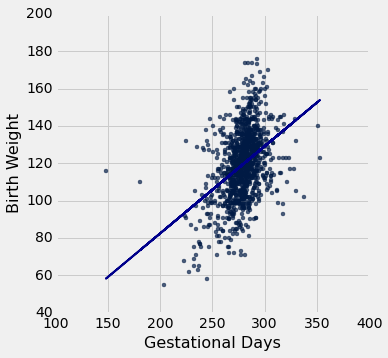

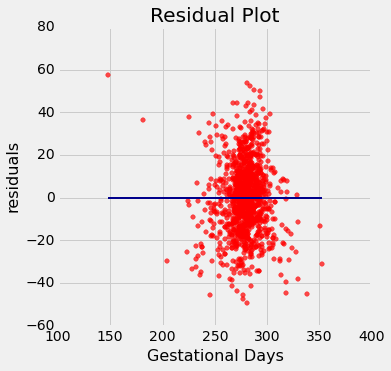

In [32]:
regression_diagnostic_plots(baby, 'Gestational Days', 'Birth Weight')

The height of each red point in the plot above is a residual. Notice how the residuals are distributed fairly symmetrically above and below the horizontal line at 0. Notice also that the vertical spread of the plot is fairly even across the most common values of $x$, in about the 200-300 range of gestational days. In other words, apart from a few outlying points, the plot isn't narrower in some places and wider in others.

All of this is consistent with the model's assumptions that the errors are drawn at random with replacement from a normally distributed population with mean 0. Indeed, a histogram of the residuals is centered at 0 and looks roughly bell shaped.

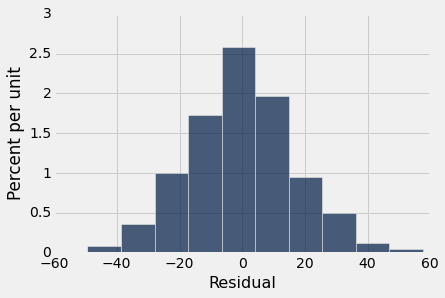

In [37]:
baby_regression.select('Residual').hist()

These observations show us that the data are fairly consistent with the assumptions of the regression model. Therefore it makes sense to do inference based on the model, as we did in the previous section.

### Using the Residual Plot to Detect Nonlinearity
Residual plots can be used to detect whether the regression model does not hold. The most serious departure from the model is non-linearity.

If two variables have a non-linear relation, the non-linearity is sometimes visible in the scatter plot. Often, however, it is easier to spot non-linearity in a residual plot than in the original scatter plot. This is usually because of the scales of the two plots: the residual plot allows us to zoom in on the errors and hence makes it easier to spot patterns.

<img src="https://upload.wikimedia.org/wikipedia/commons/7/75/Dugong_dugon.jpg"/>

As an example, we will study a [dataset](http://www.statsci.org/data/oz/dugongs.html) on the age and length of dugongs, which are marine mammals related to manatees and sea cows. The data are in a table called `dugong`. Age is measured in years and length in meters. The ages are estimated; most dugongs don't keep track of their birthdays.

In [38]:
dugong = Table.read_table('http://www.statsci.org/data/oz/dugongs.txt')
dugong

Age,Length
1,1.8
1.5,1.85
1.5,1.87
1.5,1.77
2.5,2.02
4,2.27
5,2.15
5,2.26
7,2.35
8,2.47


Here is a regression of length (the response) on age (the predictor). The correlation between the two variables is about 0.83, which is quite high.

In [40]:
correlation(dugong, 'Age', 'Length')

0.82964745549057139

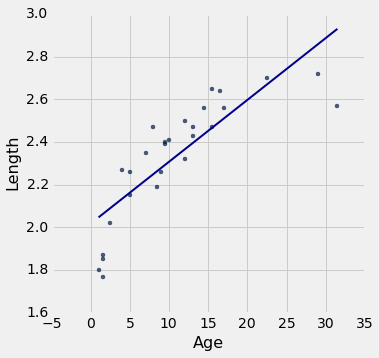

In [43]:
scatter_fit(dugong, 'Age', 'Length')

High correlation notwithstanding, the plot shows a curved pattern that is much more visible in the residual plot.

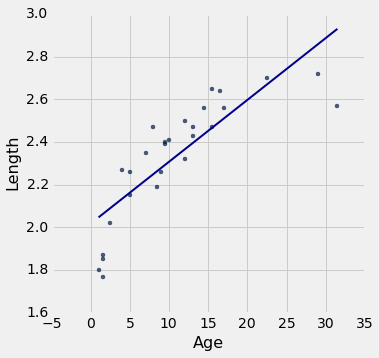

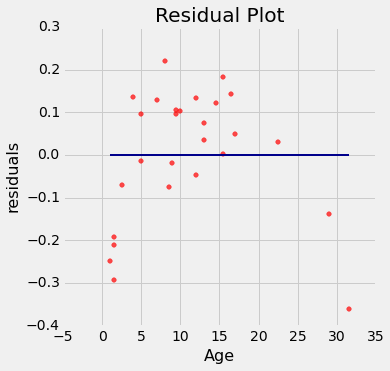

In [42]:
regression_diagnostic_plots(dugong, 'Age', 'Length')

At the low end of ages, the residuals are almost all negative; then they are almost all positive; then negative again at the high end of ages. Such a discernible pattern would have been unlikely had Tyche been picking errors at random with replacement and using them to push points off a straight line. Therefore the regression model does not hold for these data.

As another example, the dataset `us_women` contains the average weights of U.S. women of different heights in the 1970s. Weights are measured in pounds and heights in inches. The correlation is spectacularly high – more than 0.99.

In [48]:
us_women = Table.read_table('us_women.csv')
correlation(us_women, 'height', 'ave weight')

0.99549476778421608

The points seem to hug the regression line pretty closely, but the residual plot flashes a warning sign: it is U-shaped, indicating that the relation between the two variables is not linear.

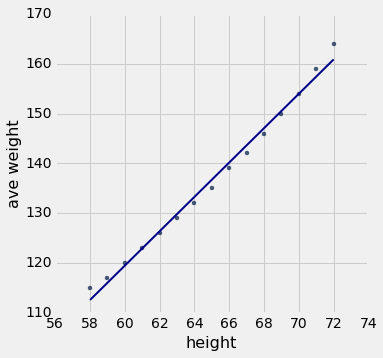

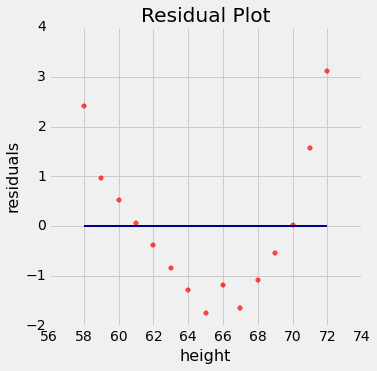

In [49]:
regression_diagnostic_plots(us_women, 'height', 'ave weight')

These examples demonstrate that even when correlation is high, fitting a straight line might not be the right thing to do. Residual plots help us decide whether or not to use linear regression.

### Using the Residual Plot to Detect Heteroscedasticity

*Heteroscedasticity* is a word that will surely be of interest to those who are preparing for Spelling Bees. For data scientists, its interest lies in its meaning, which is "uneven spread". 

Recall the table `hybrid` that contains data on hybrid cars in the U.S. Here is a regression of fuel efficiency on the rate of acceleration. The association is negative: cars that accelearate quickly tend to be less efficient.

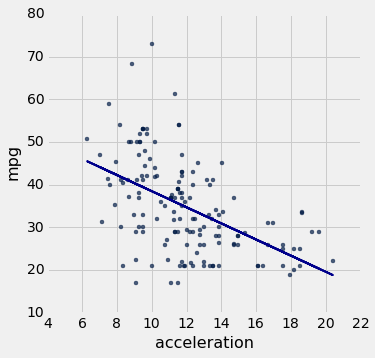

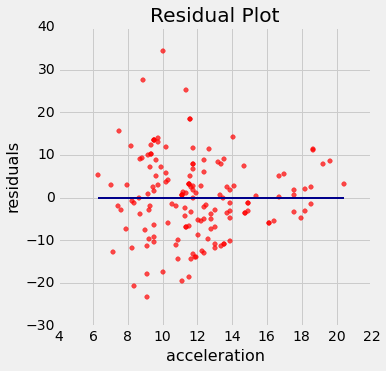

In [52]:
regression_diagnostic_plots(hybrid, 'acceleration', 'mpg')

Notice how the residual plot flares out towards the low end of the accelerations. In other words, the variability in the size of the errors is greater for low values of acceleration than for high values. Such a pattern would be unlikely under the regression model, because the model assumes that Tyche picks the errors at random with replacement *from the same normally distributed population*.

Uneven vertical variation in a residual plot can indicate that the regression model does not hold. Uneven variation is often more easily noticed in a residual plot than in the original scatter plot.

### The Accuracy of the Regression Estimate
We will end our discussion of regression by pointing out some interesting mathematical facts that lead to a measure of the accuracy of regression. We will leave the proofs to another course, but we will demonstrate the facts by examples. Note that all of the facts hold for all scatter plots, whether or not the regression model is good.

**Fact 1.**
No matter what the shape of the scatter diagram, the residuals have an average of 0. 

In all the residual plots above, you have seen the horizontal line at 0 going through the center of the plot. That is a visualization of this fact.

As a numerical example, here is the average of the residuals in the regression of birth weight on gestational days of babies:

In [53]:
np.mean(baby_regression.column('Residual'))

-6.3912532279613784e-15

That doesn't look like 0, but in fact it is a very small number that is 0 apart from rounding error.

Here is the average of the residuals in the regression of the length of dugongs on their age:

In [54]:
dugong_residuals = dugong.column('Length') - fit(dugong, 'Age', 'Length')
np.mean(dugong_residuals)

-2.8783559897689243e-16

Once again the mean of the residuals is 0 apart from rounding error. 

This is analogous to the fact that if you take any list of numbers and calculate the list of deviations from average, the average of the deviations is 0.

**Fact 2.** No matter what the shape of the scatter diagram, the SD of the fitted values is $|r|$ times the SD of the observed values of $y$.

To understand this result, it is worth noting that the fitted values are all on the regression line whereas the observed values of $y$ are the heights of all the points in the scatter plot and are more variable.

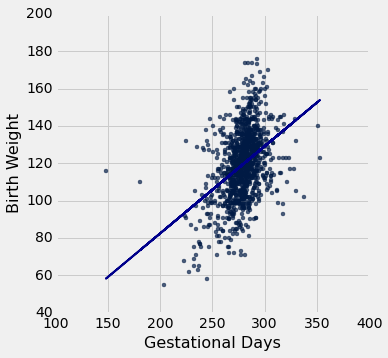

In [55]:
scatter_fit(baby, 'Gestational Days', 'Birth Weight')

The fitted values of birth weight are, therefore, less variable than the observed values of birth weight. But how much less variable?

The scatter plot shows a correlation of about 0.4:

In [56]:
correlation(baby, 'Gestational Days', 'Birth Weight')

0.40754279338885108

Here is ratio of the SD of the fitted values and the SD of the observed values of birth weight:

In [69]:
fitted_birth_weight = baby_regression.column('Fitted Value')
observed_birth_weight = baby_regression.column('Birth Weight')
np.std(fitted_birth_weight)/np.std(observed_birth_weight)

0.40754279338885108

The ratio is $r$. Thus the SD of the fitted values is $r$ times the SD of the observed values of $y$.

The example of fuel efficiency and acceleration is one where the correlation is negative:

In [58]:
correlation(hybrid, 'acceleration', 'mpg')

-0.5060703843771186

In [68]:
fitted_mpg = fit(hybrid, 'acceleration', 'mpg')
observed_mpg = hybrid.column('mpg')
np.std(fitted_mpg)/np.std(observed_mpg)

0.5060703843771186

The ratio of the two SDs is $|r|$. Thus the SD of the fitted values is $|r|$ times the SD of the observed values of fuel efficiency.

The relation says that the closer the scatter diagram is to a straight line, the closer the fitted values will be to the observed values of $y$, and therefore the closer the variance of the fitted values will be to the variance of the observed values. 

Therefore, the closer the scatter diagram is to a straight line, the closer $r^2$ will be to 1, and the closer $r$ will be to 1 or -1.

**Fact 3.** No matter what the shape of the scatter diagram, the SD of the residuals is $\sqrt{1-r^2}$ times the SD of the observed values of $y$. In other words, the root mean squared error of regression is $\sqrt{1-r^2}$ times the SD of $y$.

This fact gives a measure of the accuracy of the regression estimate.

Again, we will demonstrate this by example. In the case of gestational days and birth weights, $r$ is about 0.4 and $\sqrt{1-r^2}$ is about 0.91:

In [60]:
r = correlation(baby, 'Gestational Days', 'Birth Weight')
np.sqrt(1 - r**2)

0.91318611003278638

In [70]:
residuals = baby_regression.column('Residual')
observed_birth_weight = baby_regression.column('Birth Weight')
np.std(residuals)/np.std(observed_birth_weight)

0.9131861100327866

Thus the SD of the residuals is $\sqrt{1-r^2}$ times the SD of the observed birth weights.

It will come as no surprise that the same relation is true for the regression of fuel efficiency on acceleration:

In [63]:
r = correlation(hybrid, 'acceleration', 'mpg')
np.sqrt(1 - r**2)

0.862492183185677

In [71]:
residuals = hybrid.column('mpg') - fitted_mpg
observed_mpg = hybrid.column('mpg')
np.std(residuals)/np.std(observed_mpg)

0.862492183185677

Let us examine the extreme cases of the general fact that the SD of the residuals is $\sqrt{1-r^2}$ times the SD of the observed values of $y$. Remember the residuals always average out to 0.
- If $r=1$ or $r=-1$, then $\sqrt{1-r^2} = 0$. Therefore the residuals have an average of 0 and an SD of 0 as well; therefore, the residuals are all equal to 0. This is consistent with the observation that if $r = \pm 1$, the scatter plot is a perfect straight line and there is no error in the regression estimate. 
- If $r=0$, the $\sqrt{1-r^2} =1$ and the SD of the regression estimate is equal to the SD of $y$. This is consistent with the observation that if $r=0$ then the regression line is a flat line at average of $y$, and the root mean square error of regression is the root mean squared deviation from the average of $y$, which is the SD of $y$.

For every other value of $r$, the rough size of the error of the regression estimate is somewhere between 0 and the SD of $y$.